# Van Der Pol oscillator in Numpy

The equation inside this code is the second-order Van der Pol oscillator equation, which describes the motion of a damped oscillator subject to a nonlinear restoring force. The equation is given by:

d^2u/dt^2 - w0^2 * u + eps * w0 * (1 - u^2) * du/dt = 0

where u is the displacement of the oscillator from its equilibrium position, t is time, w0 is the natural frequency of the oscillator, and eps is the strength of the nonlinear restoring force.

The equation is solved numerically using the solve_ivp function from the scipy.integrate module, which implements the Runge-Kutta method for solving ordinary differential equations. The initial conditions and parameters are set, and a time grid is defined using np.linspace. The solve_ivp function is then called with the Van der Pol equation, initial conditions, parameters, and time grid as inputs.

The resulting solution is a plot of the displacement u as a function of time t, which shows the behavior of the oscillator over the given time span it is also compared with the exact solution. The plot exhibits periodic behavior, with the amplitude of the oscillations varying over time due to the nonlinear restoring force. The plot can be interpreted as showing the motion of the oscillator over time, with the peaks and valleys of the plot corresponding to the maximum and minimum displacements of the oscillator, respectively.

### Hardware Information

In [2]:
#pip install py-cpuinfo
import platform
import cpuinfo

# Get the platform and processor information
platform_info = platform.platform()
processor = platform.processor()

# Get the CPU information
cpu_info = cpuinfo.get_cpu_info()['brand_raw']
print("Platform: ", platform_info)
print("Processor: ", processor)
print("CPU: ", cpu_info)


Platform:  Windows-10-10.0.22621-SP0
Processor:  Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU:  Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz


In [3]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from __future__ import division, print_function
import sys
import numpy as np
from scipy.integrate import solve_ivp

def runge_kutta4(func, r, t, omega, nu, h):
    
    k1 = h*func(r, t, omega, nu)
    k2 = h*func(r+0.5*k1, t+0.5*h, omega, nu)
    k3 = h*func(r+0.5*k2, t+0.5*h, omega, nu)
    k4 = h*func(r+k3, t+h, omega, nu)
    return (k1 + 2*k2 + 2*k3 + k4)/6
   
def pendule_Function(r, t, omega, nu):
    """ vectorized function for the pendule """
    x = r[0]
    v = r[1]
    fx = v
    fv = -omega**2 * x  +  nu*(1 - x**2)*v
    return np.array([fx,fv], float)

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
    

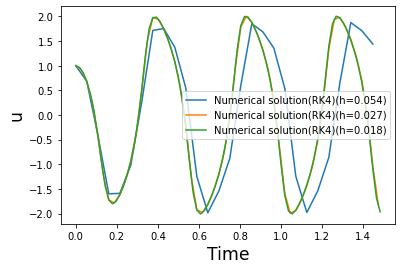

In [43]:
plt.figure()
for i in range(1,4):
    # We define the time step for RK4 numerical integration ... is important also for visualization
    
    #Define omega0 and nu parameters .................
    w0 = 15.
    nu=15.        # This is epsilon * w0 (nu = 5 -> epsilon = 1/3) ...................

    # We integrate between tMin and tMax .............
    tMin,tMax = 0.0,1.5
    tStep = (tMax-tMin)/(28*i)

    tPoints = np.arange(tMin, tMax, tStep)
    xPoints,vPoints = [],[]

    # set initial conditions on the state variables ..........
    x0,v0 = 1.,0.
    r = np.array([x0,v0], float)

    # solve for the time evolution for the true solution obtained with Runge-kutta of order 4 integration
    for t in tPoints:
        xPoints += [r[0]]
        vPoints += [r[1]]
        r += runge_kutta4(pendule_Function, r, t, w0, nu, tStep)

    
    plt.plot(tPoints, xPoints, label="Numerical solution(RK4)(h={})".format(round(tStep,3)))
    plt.xlabel("Time",fontsize="xx-large")
    plt.ylabel("u",fontsize="xx-large")
    #plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
    plt.legend()
    plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

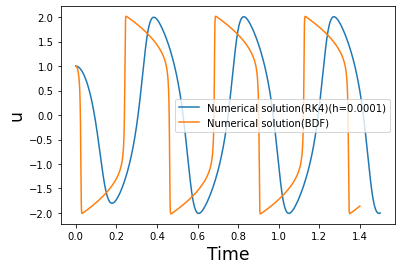

In [46]:
# We define the time step for RK4 numerical integration ... is important also for visualization
nSteps=10000
#Define omega0 and nu parameters .................
w0 = 15.
nu=15.        # This is epsilon * w0 (nu = 5 -> epsilon = 1/3) ...................

# We integrate between tMin and tMax .............
tMin,tMax = 0.0,1.5
tStep = (tMax-tMin)/(nSteps)

tPoints = np.arange(tMin, tMax, tStep)
xPoints,vPoints = [],[]

# set initial conditions on the state variables ..........
x0,v0 = 1.,0.
r = np.array([x0,v0], float)

# solve for the time evolution for the true solution obtained with Runge-kutta of order 4 integration
for t in tPoints:
    xPoints += [r[0]]
    vPoints += [r[1]]
    r += runge_kutta4(pendule_Function, r, t, w0, nu, tStep)


x=torch.Tensor(tPoints).view(-1,1)
y=torch.Tensor(xPoints).view(-1,1)

# We select only some points (one over 10 for example) for future comparison with true solution
x = x[::10]
y = y[::10, :]

# We select a very few data points to be used in the normal Neural netwok -> training data ...
x_data=x[0:20:20]
y_data=y[0:20:20]

#numerical sol
def van_der_pol_osci(t, y, w_0, epsi):
    u, du_dt = y
    d2u_dt2 = -w_0**2 * u + epsi * w_0 * (1 - u**2) * du_dt
    return [du_dt, d2u_dt2]

w_0 = 40.
epsi = 9.
tspan = (0.0, 1.4)
y0 = [1.0, 0.0]
# Define the time grid
teval = np.linspace(tspan[0], tspan[1], 10000)
# Solve the equation using solve_ivp
sol = solve_ivp(van_der_pol_osci, tspan, y0, args=(w_0, epsi), t_eval=teval)

# We plot data of the true solution and the training data .............................
plt.figure()
plt.plot(tPoints, xPoints, label="Numerical solution(RK4)(h={})".format(round(tStep,4)))
plt.plot(sol.t, sol.y[0], label ="Numerical solution(BDF)")
plt.xlabel("Time",fontsize="xx-large")
plt.ylabel("u",fontsize="xx-large")
#plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show


# Normal neural network

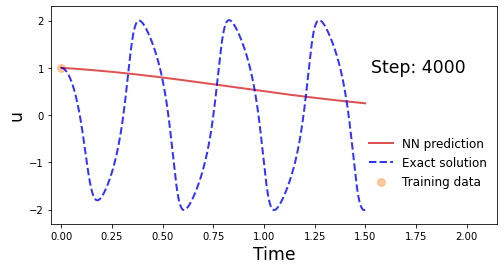

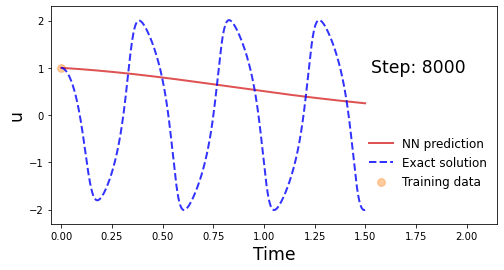

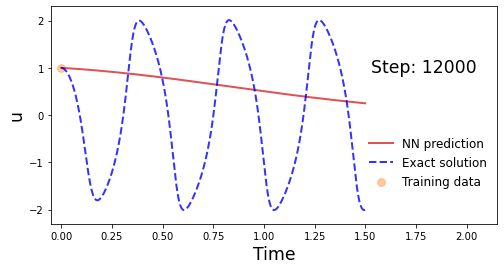

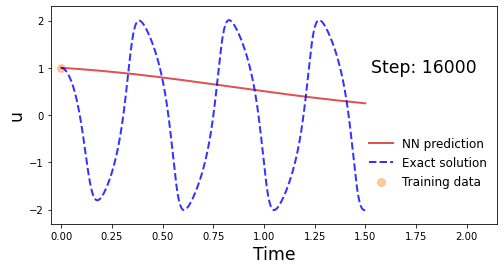

In [3]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,yh, color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
    plt.plot(x,y, color="blue", linewidth=2, alpha=0.8, linestyle='--', label="Exact solution")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=30, color="tab:green", alpha=0.4, 
                    label='Colloc. points')
    l = plt.legend(loc=(0.701,0.14), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05,2.15)
    plt.ylim(-2.3, 2.3)
    plt.text(1.525,0.9,"Step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.ylabel('u',fontsize="xx-large")
    plt.xlabel('Time',fontsize="xx-large")
    plt.axis("on")
        
# We train a standard neural network to fit training data (one must choos lr and number of
# layers, number of neurons per layer) ....................................................
torch.manual_seed(127)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
for i in range(16000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error to define Loss on data ......
    loss.backward()
    optimizer.step()
        
    # plot the result as training progresses ..............................................
    if (i+1) % 100 == 0:         
        yh = model(x).detach()       
        plot_result(x,y,x_data,y_data,yh)   
        if (i+1) % 4000 == 0: plt.show()
        else: plt.close("all")
            

# PINN

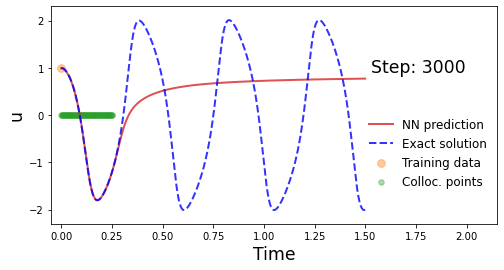

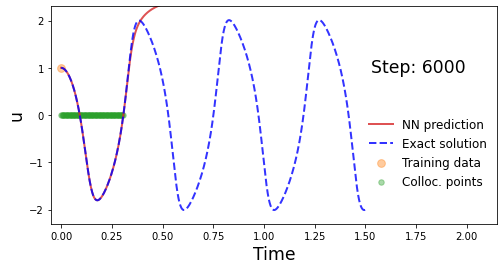

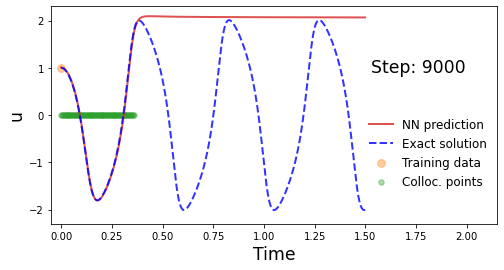

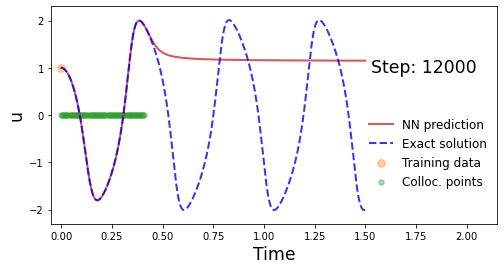

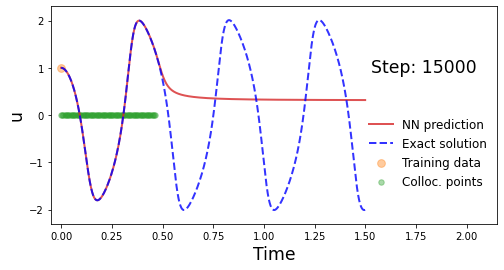

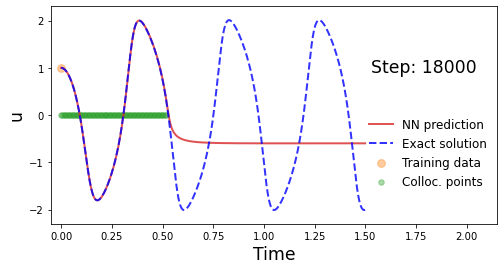

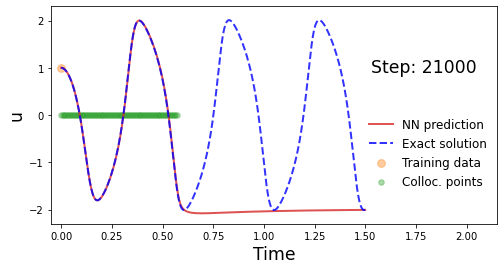

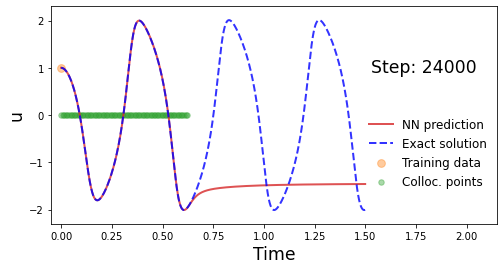

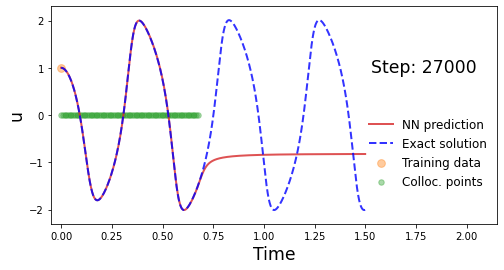

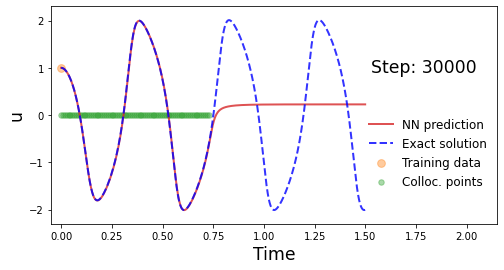

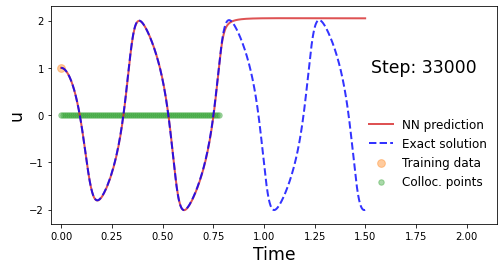

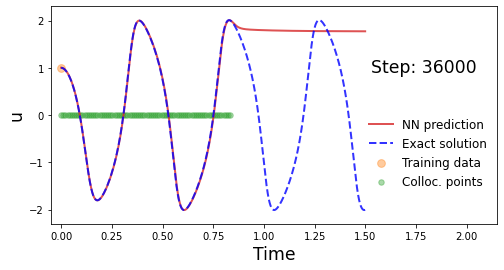

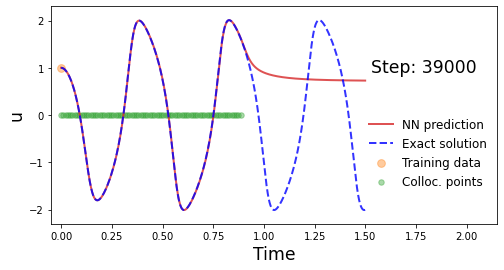

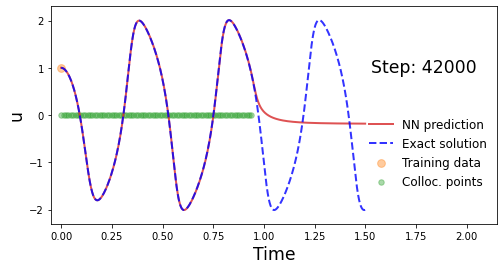

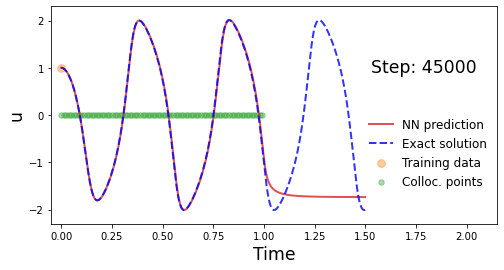

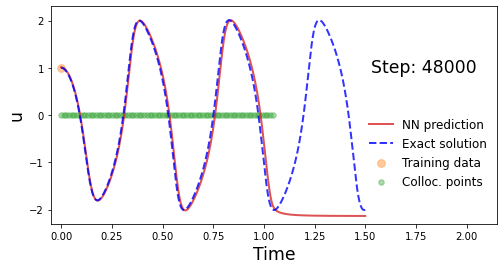

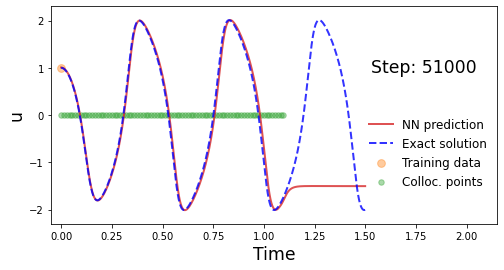

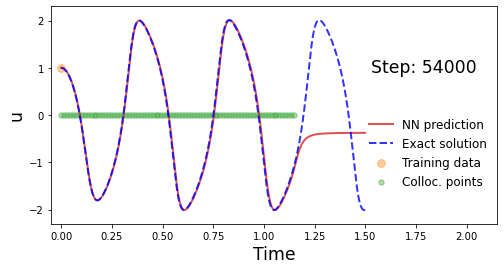

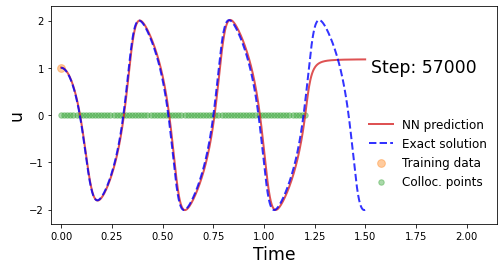

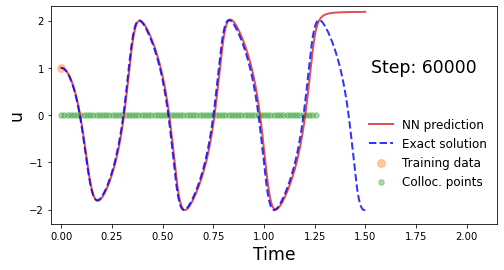

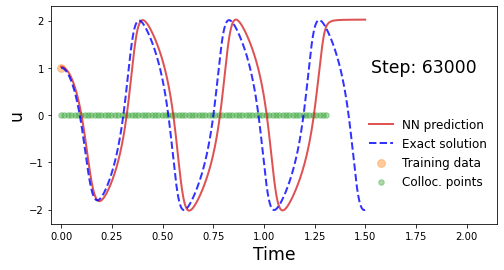

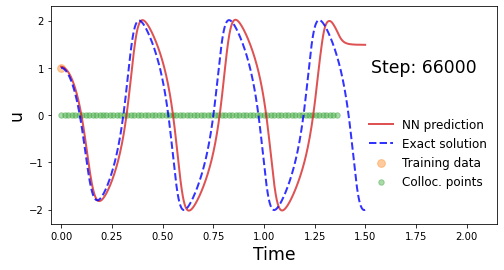

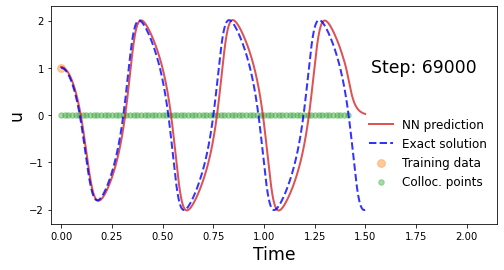

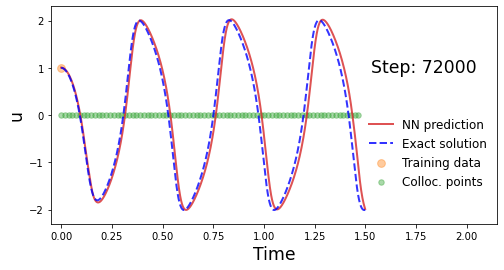

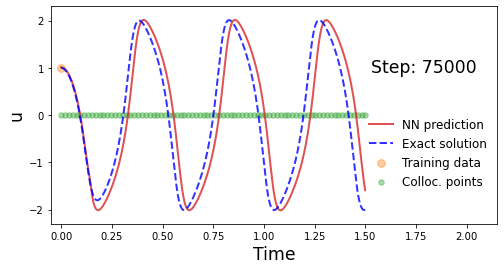

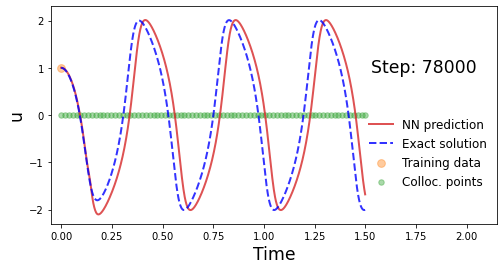

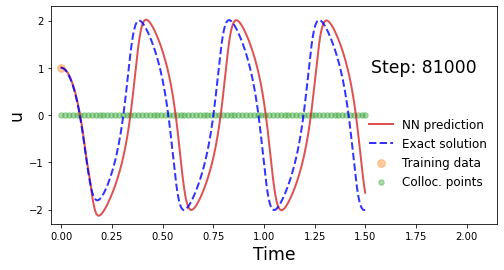

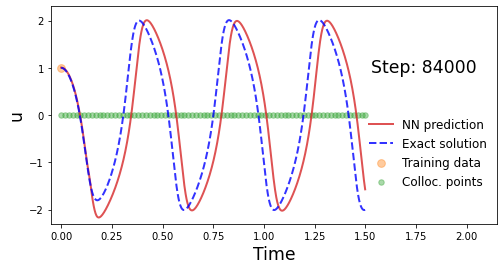

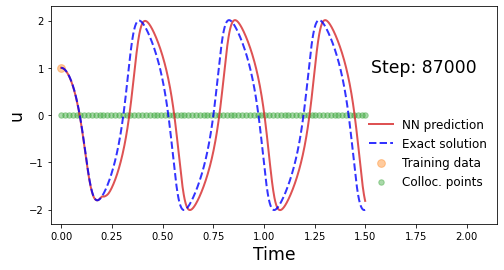

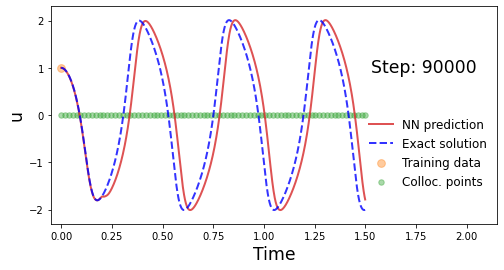

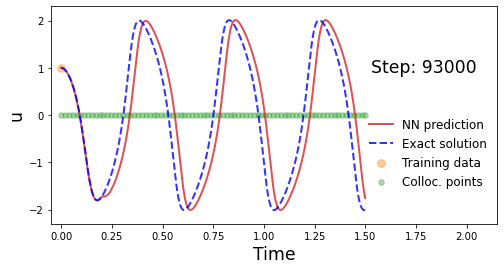

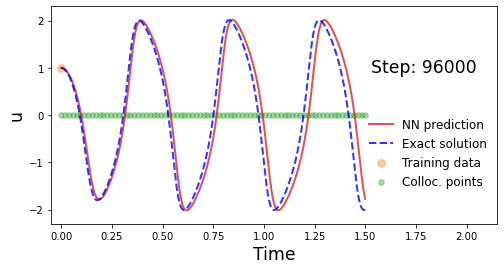

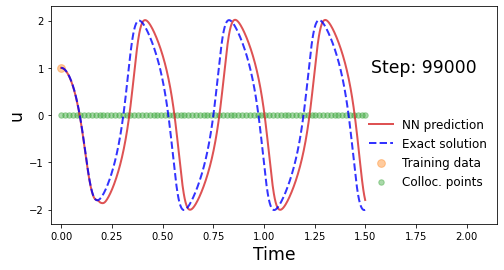

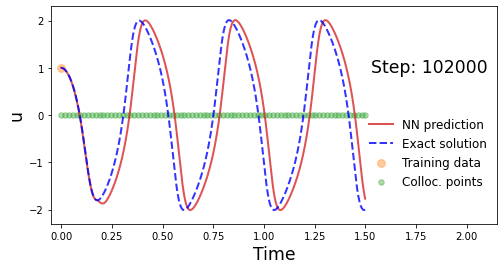

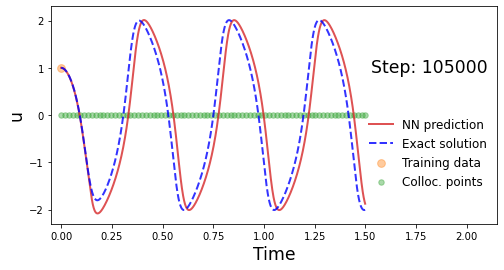

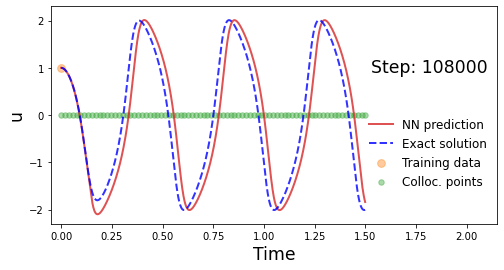

In [4]:
# ...................
ww=w0
torch.manual_seed(125)
model = FCN(1,1,42,4)

optimizer = torch.optim.Adam(model.parameters(),lr=7e-4)
files = []
loss1_history = []
loss2_history = []
loss_history = []
mse_history = []

for i in range(109000):
    # the range of colocation points is increasing with a moving right boundary .....
    lim=0.2 + np.minimum(1.3*i/74000.,1.3)       
    x_physics = torch.linspace(0.,lim,80).view(-1,1).requires_grad_(True)#
    optimizer.zero_grad()
        
    # compute the first part of the "data loss" .....
    yh = model(x_data)
    loss1 = 1*torch.mean((yh-y_data)**2)  # use mean squared error (the weight is taken to be 1)
    
    # compute the "physics loss" with enforcing the initial data ........................
    yhp = model(x_physics)
    # compute first and second derivatives by automatic differentiation .........................
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    
    # second part of loss1 .............
    loss1 = loss1 + 0.1*torch.max((dx[0])**2)
    
    # computes the equation residual ........................................
    physics= (dx2 + ww**2*yhp - nu*(1 - yhp*yhp)*dx)   # This is the equation ................
    loss2 = (1e-4)*torch.mean(physics**2)    # Loss on physics with a chosen weight ..........
    yhpp=model(x)
    mse=torch.mean((yhpp-y)**2)   # compute mean square error using exact solution ............

    # backpropagate the total loss .......................................................
    loss = loss1 + loss2  # add two loss terms together ..................................
    loss.backward()
    optimizer.step()    
        
    # plot the result as training progresses ...............................
    if (i+1) % 100 == 0: 
        loss1_history.append(loss1.detach())
        loss2_history.append(loss2.detach())
        loss_history.append(loss.detach())
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        yhpp=model(x)
        mse=torch.mean((yhpp-y)**2)   # compute mean square error using exact solution .....
        mse_history.append(mse.detach())

        
        plot_result(x,y,x_data,y_data,yh,xp)
           
        if (i+1) % 3000 == 0: plt.show()
        else: plt.close("all")
            

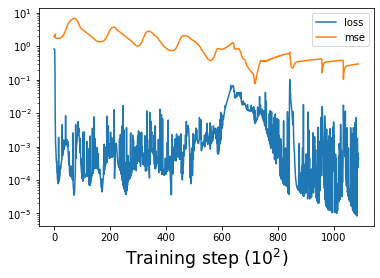

In [5]:
fig33 = plt.figure(33)
plt.plot(loss_history, label="loss")
plt.plot(mse_history, label="mse")
plt.xlabel('Training step ($10^2$)',fontsize="xx-large")
plt.yscale('log')
plt.legend()

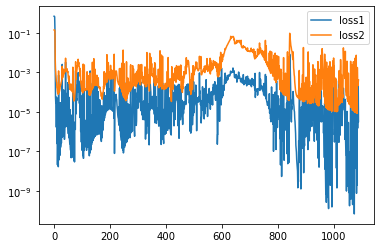

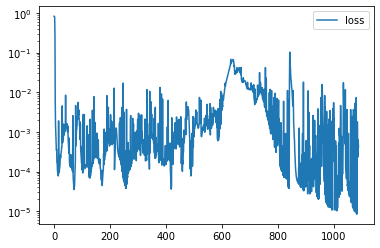

In [6]:
fig50 = plt.figure(50)
plt.plot(loss1_history, label="loss1")
plt.plot(loss2_history, label="loss2")
plt.yscale('log')
plt.legend()

fig51 = plt.figure(51)
plt.plot(loss_history, label="loss")
plt.yscale('log')
plt.legend()

Text(0.5, 1.0, 'error')

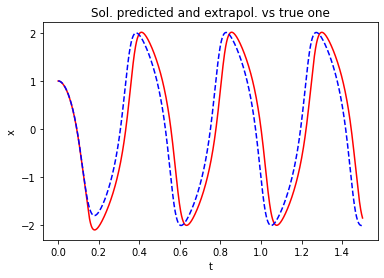

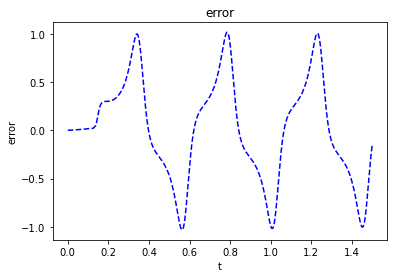

In [7]:
xn = torch.linspace(0.,1.5,1000).view(-1,1)
yh2 = model(xn).detach()
        
# plot extrapolate    
fig5 = plt.figure(5)
plt.plot(xn, yh2, color="red")
plt.plot(tPoints, xPoints, color="blue",linestyle='--')
#plt.plot(xn, yth)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Sol. predicted and extrapol. vs true one")

err=y-yh2

fig6 = plt.figure(6)
plt.plot(xn, err, color="blue",linestyle='--')
#plt.plot(xn, yth)
plt.xlabel("t")
plt.ylabel("error")
plt.title("error")


